# Project Part 2 Solutions

## (a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = np.load("part2.npz")
beta_old = file['beta_old'] #4 x 4, parameter
N = file['N'] #100 thingies
Svc_0_PMF = file['Svc_0_PMF'] #100 nodes, each one 4x4
Lc = file['Lc'] #array([0.3, 0.4, 0.7, 1. ])
Ic_0 = file['Ic_0'] #100 x 4, 100 nodes, 4 c values
gamma = file['gamma'] #array(0.07142857)
L_observed = file['L_observed'] #(100, 120), 100 nodes, for each node we have 120 days
nb_nodes = Svc_0_PMF.shape[0] #100 nodes

In [3]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [4]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

#N is the total population. Size 100
    #N_node is going through the values in N
#nb_nodes is 100
    #node_index is the range (0, 99)
for N_node, node_index in zip(N, range(nb_nodes)):

    #Initial conditions updated depending on the node
    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    #goes through all the nodes (rows), but only 10 days (colums 0..9)
    L[node_index, :10] = Lc@soln.y[16:20]

#print("S:", S[node_index, :, :, 9])
#print("I:",I[node_index, :, 9])
#print("R:",[R[node_index, 9]])

alpha_predicted = np.zeros((nb_nodes))

def loss_func(alpha):  
    # Solve for values on day 10-29
    #Initial conditions on day 9, depending on the node
    initial_conditions = np.concatenate(
        (S[node_index, :, :, 9].flatten(), I[node_index, :, 9], [R[node_index, 9]]))

    soln = solve_ivp(SIR, (t[10], t[29]), initial_conditions, args=(N_node, beta_old*alpha, gamma), t_eval=t[10:30])

    S[node_index, :, :, 10:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:30] = soln.y[16:20]
    R[node_index, 10:30] = soln.y[20]
    #goes through all the nodes (rows), but only 10 days (colums 0..9)
    L[node_index, 10:30] = Lc@soln.y[16:20]

    # Compare the first 120 columns (days)
    mse = mean_squared_error(L_observed[node_index, 10:30], L[node_index,10:30])
  
    return mse

for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)

# Print out alpha_predicted
print("Alpha_Predicted Values:\n", alpha_predicted, "\n")

# Rank nodes by their alpha values
order = alpha_predicted.argsort()
ranks = order.argsort()
print("Alpha_Predicted Values from Lowest to Highest:\n", alpha_predicted[order], "\n")
print("Ranks of the Nodes:\n", ranks)

Alpha_Predicted Values:
 [0.22669983 0.39484253 0.22185059 0.73707123 0.70143738 0.20029602
 0.35754395 0.35007172 0.3601532  0.16713867 0.27568665 0.32045898
 0.31580811 0.20931396 0.12352142 0.22246094 0.18051758 0.56386719
 0.59924927 0.14249268 0.26811523 0.27178955 0.49281006 0.26390381
 0.33642883 0.15171814 0.3757782  0.21018066 0.44144897 0.68422394
 0.29797363 0.3010498  0.39297028 0.16387329 0.61907349 0.66160202
 0.3225708  0.15137939 0.28189697 0.90992126 0.41170807 0.43126221
 0.43154907 0.17045288 0.24889221 0.41756592 0.71300049 0.330896
 0.23173828 0.20965576 0.13822021 0.20452881 0.33418884 0.26639404
 0.14807129 0.66747131 0.17644043 0.53582764 0.27561264 0.56835938
 0.36387939 0.27543945 0.34067383 0.42473755 0.24645996 0.52313232
 0.20018311 0.38779907 0.46865234 0.1552803  0.14443359 0.33525391
 0.2932373  0.44838867 0.41690369 0.30296936 0.56982422 0.66409302
 0.37408447 0.20103149 0.32358704 0.51626587 0.72009888 0.35155029
 0.28358765 0.28780823 0.25011292 0.542

## (b)

In [5]:
# Helper functions for total_recovered_difference
def getR_predicted(alpha_predicted):
    totR = 0
    for N_node, node_index in zip(N, range(nb_nodes)):
        initial_conditions = np.concatenate((S[node_index, :, :, 9].flatten(), I[node_index, :, 9], [R[node_index, 9]]))

        soln = solve_ivp(SIR, (t[10], t[199]), initial_conditions, args=(N_node, beta_old*alpha_predicted[node_index], gamma), t_eval=t[10:200])

        S[node_index, :, :, 10:200] = soln.y[:16].reshape(4, 4, -1)
        I[node_index, :, 10:200] = soln.y[16:20]
        R[node_index, 10:200] = soln.y[20]
        #goes through all the nodes (rows), but only 10 days (colums 0..9)
        L[node_index, 10:200] = Lc@soln.y[16:20]

        totR += R[node_index][-1]

    return totR

def getR_afterNPI(alpha_afterNPI):
    totR = 0
    for N_node, node_index in zip(N, range(nb_nodes)):
        initial_conditions = np.concatenate((S[node_index, :, :, 29].flatten(), I[node_index, :, 29], [R[node_index, 29]]))

        soln = solve_ivp(SIR, (t[30], t[199]), initial_conditions, args=(N_node, beta_old*alpha_afterNPI[node_index], gamma), t_eval=t[30:200])

        S[node_index, :, :, 30:200] = soln.y[:16].reshape(4, 4, -1)
        I[node_index, :, 30:200] = soln.y[16:20]
        R[node_index, 30:200] = soln.y[20]
        #goes through all the nodes (rows), but only 10 days (colums 0..9)
        L[node_index, 30:200] = Lc@soln.y[16:20]

        totR += R[node_index][-1]

    return totR

In [6]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):
    
    R_old_alpha = getR_predicted(alpha_predicted)
    R_afterNPI = getR_afterNPI(alpha_afterNPI)
    
    return R_afterNPI - R_old_alpha

### Policy #1

i

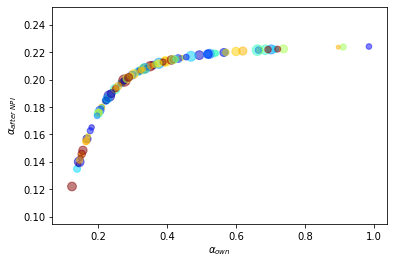

In [7]:
# Empty placeholder for alpha_NPI
alpha_afterNPI = np.zeros(100)

# Use g and g_inv to update alpha
for i in range(len(alpha_predicted)):
    x = g_inv(alpha_predicted[i])
    alpha_afterNPI[i] = (g(x + 10000))

#print(alpha_afterNPI)

scatter_plot(alpha_afterNPI)

ii

In [8]:
print("Total Recovered Difference with Policy 1: ", int(total_recovered_difference(alpha_afterNPI)))

Total Recovered Difference with Policy 1:  -329893


### Policy #2

i. 

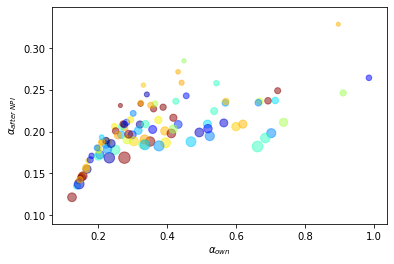

In [9]:
# Empty placeholder for alpha_NPI
alpha_afterNPI = np.zeros(100)

# Use g and g_inv to update alpha
for i in range(len(alpha_predicted)):
    x = g_inv(alpha_predicted[i])
    alpha_afterNPI[i] = (g(x + (N[i]/np.sum(N))*1000000))

#print(alpha_afterNPI)

scatter_plot(alpha_afterNPI)

ii.

In [10]:
print("Total Recovered Difference with Policy 2: ", int(total_recovered_difference(alpha_afterNPI)))

Total Recovered Difference with Policy 2:  -346022


### Policy #3

i.

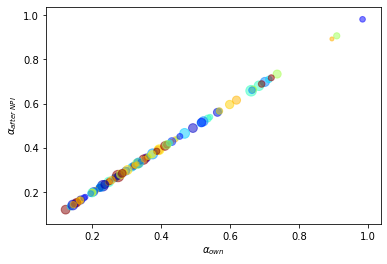

In [11]:
# Spend the budget such that αown−αafter NPI is the same for all nodes, that is the change in α induced by the NPI is the same for all nodes. To do this, you can again use scipy.optimize.fmin.
# Write a function that takes in a value for change in α := ∆α and returns the difference between
# the budget that corresponds to this ∆α and $1,000,000. By using fmin on this function we find
# the value of ∆α that corresponds to the budget of $1,000,000.

#in: ∆α, out: $ 

def alpha_loss_func(delta):
    newdelta = alpha_predicted + delta
    total = 0
    for i in newdelta:
        total += g_inv(i)
    return abs(1000000 - total)

delta = fmin(alpha_loss_func, 0.5, disp=False)

alpha_afterNPI = alpha_predicted - delta

scatter_plot(alpha_afterNPI)

ii.

In [12]:
print("Total Recovered Difference with Policy 3: ", int(total_recovered_difference(alpha_afterNPI)))

Total Recovered Difference with Policy 3:  -7836


### Policy #4

i.

Spend the budget based on each node's $\alpha_{own}$ and try to bring all nodes $\alpha$'s to a similar level

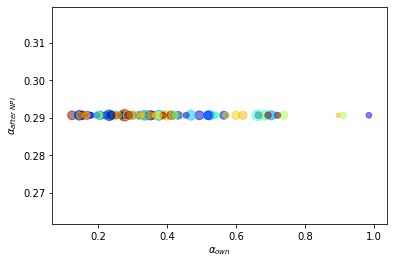

In [13]:
alpha_afterNPI = np.zeros(100)

def alpha_loss_func2(alpha):
    total = 0
    for i in alpha_predicted:
        # If the target alpha is already lower than a given node's αown, you wouldn't spend any money on it.
        if alpha >= i:
            total += g_inv(i)    
    return(abs(1000000 - total))

for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_afterNPI[node_index] = fmin(alpha_loss_func2, 0.5, disp=False)

#print(alpha_afterNPI)
scatter_plot(alpha_afterNPI)

ii.

In [14]:
print("Total Recovered Difference with Policy 4: ", int(total_recovered_difference(alpha_afterNPI)))

Total Recovered Difference with Policy 4:  -113080


## (c)

### Policy 1

This pollicy is fair in some senses because we give each node the same amount of money which makes it so that there is less bias involved. However, one may also have to consider the fact that some of the nodes may need the money more than others, for example places that are already doing well may not need the money. From a utalitarian stand point, saving the most amount of lives possible the most fair way to go about this, therefore because there are more recovered people than not it can be seen as fair.

### Policy 2

Spending according to the population of the node can be seen through the lense of fairness because it is a logical assumption to assume that in areas that are more densely populated more money may be needed in order to help the populalation at large. On the other hand, it is possible to see it from the perpective that an area with a smaller population may need more resources than an area with a greater population. Furthermore, the economics and other factors are not being looked at from this point of view. From the utalitarian point of view this is the policy that makes the most sense because it is theoretically helping the most people.

### Policy 3

By spending the budget to make up for the fact that some populations have larger alpha values than other populations, we are effectively offsetting the 'disadvantage' certain populations may have as a result of having a lower alpha value (this may be correlated with the communities understanding of the virus being lower which then may make sense to spend more money on increased awareness). Where this may be a major con is that it may be over-considering the importance of the alpha value and not distributing the money correctly. Given a lack of understanding in the importance in how each paramter effects the population, it may be considered fair to go about this method if this is the best of the knowledge available.

### Policy 4

By equalizing the alpha values, our situation results in equity for everyone. This means that regardless of N, v, and c values, we will have the same outcome for every node. This can seem fair at first glance, but if you look closer you'll notice that there will undoubtedly be nodes that start off with a higher value. These populations will not receive budgeting; and although our intentions are pure, people will not take kindly to not receiving funding for their homes. Thus, this is not an optimal way to disburse funding for the NPI, as many people will not be happy.